negative sampling  

num_features = 3

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from feature_eng import WordAndDoc2vec

In [3]:
import os.path
import sys
import re
import itertools
import csv
import datetime
import pickle
import random
from collections import defaultdict, Counter
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import gensim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import gensim
from keras.preprocessing.sequence import skipgrams
import tensorflow as tf
from keras import backend as K

In [4]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, cmap=cmap, **kwargs)
def scatter(x, y, color, **kwargs):
    plt.scatter(x, y, marker='.')

### create sample data

In [5]:
NN_word = 2000
NN_sentence = 10000
NN_SEG = 7

In [6]:
product_list = [ee+1 for ee in range(NN_word)]
user_list = [ee+1 for ee in range(NN_sentence)]

In [7]:
a, _ = divmod(len(user_list), NN_SEG)
print(a)
cls_user = [int(user_id / (a+1)) for user_id in range(1, 1+len(user_list))]

1428


In [8]:
a, _ = divmod(len(product_list), NN_SEG)
print(a)
cls_prod = [int(prod_id / (a+1)) for prod_id in range(1, 1+len(product_list))]

285


In [9]:
random.seed(0)

X_list = []

for ii in range(len(user_list)):
    cls = cls_user[ii]
    product_group = np.array(product_list)[np.array(cls_prod) == cls]
    nword = random.randint(5, 20)
    prods = random.sample(product_group.tolist(), nword)
    irow = np.zeros((1,NN_word))
    irow[0,np.array(prods)-1] = 1
    X_list.append(irow)

X = np.concatenate(X_list)
print(X.shape)
X

(10000, 2000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
X_df = pd.DataFrame(X, dtype=int)
X_df.index = ['r'+ee.astype('str') for ee in (np.arange(X_df.shape[0])+1)]
X_df.columns = ['c'+ee.astype('str') for ee in np.arange(X_df.shape[1])+1]
print(X_df.shape)
X_df.head()

(10000, 2000)


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c1991,c1992,c1993,c1994,c1995,c1996,c1997,c1998,c1999,c2000
r1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
r2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
r3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
r4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
r5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_df.values.shape

(10000, 2000)

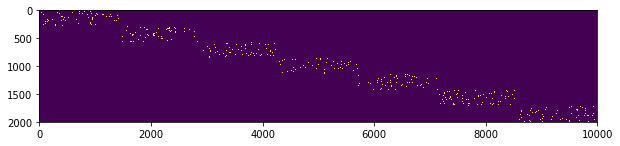

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(X_df.values.T)

In [13]:
K.floatx()

'float32'

In [14]:
from collections.abc import Sequence

class DocSeq(Sequence):
    '''
    doc_dic  : doc_name (unique)
    word_dic : index=0 must be place holder.
    '''
    def __init__(self, df):
        self.df = df
        self.cols = self.df.columns.values
        
        self.doc_dic = gensim.corpora.Dictionary([df.index.values.tolist()], prune_at=None)
        
        
        '''
        index=0 must be place holder.
        '''
        self.word_dic = gensim.corpora.Dictionary([['PL_DUMMY']], prune_at=None)
        
        self.word_dic.add_documents([list(self.cols)], prune_at=None)
    
    def __getitem__(self, idx):
        return self._get(idx)
    
    def _get(self, idx):
        try:
            ebid = self.doc_dic[idx]
        except KeyError:
            raise IndexError
        irow = self.df.loc[ebid]
        res = []
        for icol in self.cols:
            if irow[icol] == 1:
                res.append(icol)
        return res
    
    def __len__(self):
        return self.df.shape[0]

In [15]:
doc_seq = DocSeq(X_df)
len(doc_seq)

10000

In [16]:
doc_seq[0]

['c21',
 'c49',
 'c72',
 'c76',
 'c112',
 'c129',
 'c133',
 'c145',
 'c156',
 'c184',
 'c208',
 'c216',
 'c245',
 'c249',
 'c259',
 'c262',
 'c273']

In [17]:
doc_seq.word_dic[0]

'PL_DUMMY'

In [18]:
doc_seq.doc_dic[1]

'r2'

In [19]:
wd2v = WordAndDoc2vec(doc_seq, doc_seq.word_dic, doc_seq.doc_dic, logging=False)
wd2v

len(doc_seq) >>> 10000
max(doc_dic.keys()) + 1 >>> 10000
num_features >>> 2001
corpus_csr.shape >>> (10000, 2001)
creating tfidf...


In [20]:
wd2v.dic4seq['r1']

['c21',
 'c21',
 'c21',
 'c21',
 'c21',
 'c21',
 'c21',
 'c21',
 'c21',
 'c49',
 'c49',
 'c49',
 'c49',
 'c49',
 'c49',
 'c49',
 'c49',
 'c49',
 'c72',
 'c72',
 'c72',
 'c72',
 'c72',
 'c72',
 'c72',
 'c72',
 'c72',
 'c76',
 'c76',
 'c76',
 'c76',
 'c76',
 'c76',
 'c76',
 'c76',
 'c76',
 'c112',
 'c112',
 'c112',
 'c112',
 'c112',
 'c112',
 'c112',
 'c112',
 'c112',
 'c112',
 'c129',
 'c129',
 'c129',
 'c129',
 'c129',
 'c129',
 'c129',
 'c129',
 'c129',
 'c133',
 'c133',
 'c133',
 'c133',
 'c133',
 'c133',
 'c133',
 'c133',
 'c133',
 'c145',
 'c145',
 'c145',
 'c145',
 'c145',
 'c145',
 'c145',
 'c145',
 'c145',
 'c156',
 'c156',
 'c156',
 'c156',
 'c156',
 'c156',
 'c156',
 'c156',
 'c156',
 'c184',
 'c184',
 'c184',
 'c184',
 'c184',
 'c184',
 'c184',
 'c184',
 'c184',
 'c208',
 'c208',
 'c208',
 'c208',
 'c208',
 'c208',
 'c208',
 'c208',
 'c208',
 'c216',
 'c216',
 'c216',
 'c216',
 'c216',
 'c216',
 'c216',
 'c216',
 'c216',
 'c245',
 'c245',
 'c245',
 'c245',
 'c245',
 'c245',
 

In [21]:
num_features = 3
#wd2v.make_model(num_features=num_features)
wd2v.make_model(num_features=num_features, embeddings_val=0.1)

{'model': <keras.engine.training.Model at 0x7f9f1b698c50>,
 'model_neg': <keras.engine.training.Model at 0x7f9f1b882cc0>,
 'model_prob': <keras.engine.training.Model at 0x7f9f1b891b38>,
 'model_prob2': <keras.engine.training.Model at 0x7f9f1b79aa90>,
 'model_prob2_cnfm': <keras.engine.training.Model at 0x7f9f1b765978>,
 'model_prob_cnfm': <keras.engine.training.Model at 0x7f9f1b7d2278>,
 'model_prod': <keras.engine.training.Model at 0x7f9f1b95fc18>,
 'model_user': <keras.engine.training.Model at 0x7f9f387f9f60>}

(2001, 3)


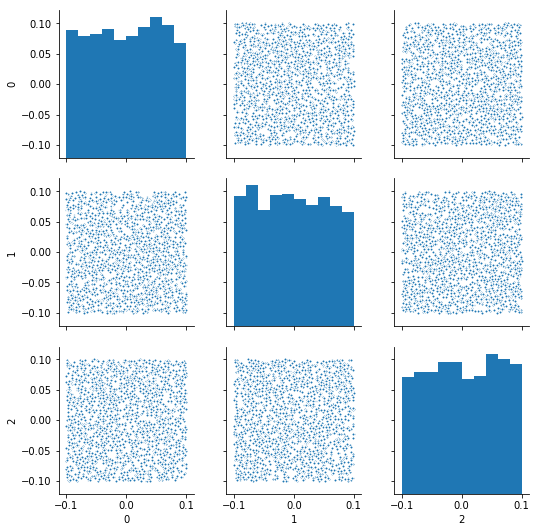

In [22]:
wgt_prod = wd2v.wgt_col
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.pairplot(df, markers='.')

(10000, 3)


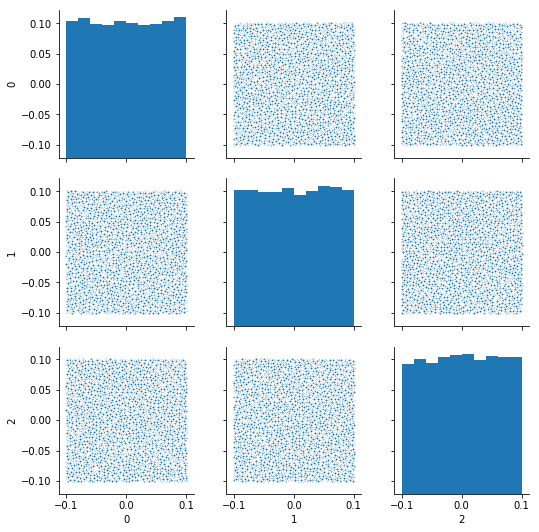

In [23]:
wgt_user = wd2v.wgt_row
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.pairplot(df, markers='.')

### 1

In [24]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

def lr_schedule(epoch):
    lr0 = 0.01
    epoch1 = 16
    epoch2 = 16
    epoch3 = 16
    epoch4 = 16
    
    if epoch<epoch1:
        lr = lr0
    elif epoch<epoch1+epoch2:
        lr = lr0/2
    elif epoch<epoch1+epoch2+epoch3:
        lr = lr0/4
    elif epoch<epoch1+epoch2+epoch3+epoch4:
        lr = lr0/8
    else:
        lr = lr0/16
    
    if divmod(epoch,4)[1] == 3:
        lr *= (1/8)
    elif divmod(epoch,4)[1] == 2:
        lr *= (1/4)
    elif divmod(epoch,4)[1] == 1:
        lr *= (1/2)
    elif divmod(epoch,4)[1] == 0:
        pass
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [lr_scheduler]

wd2v.train(epochs=64, verbose=1,
           use_multiprocessing=True, workers=4,
           callbacks=callbacks)

len(seq) >>> 313
Epoch 1/64
Learning rate:  0.01
313/313 [==============================] - 7s 21ms/step - loss: 0.7098 - acc: 0.6325
Epoch 2/64
Learning rate:  0.005
313/313 [==============================] - 6s 20ms/step - loss: 0.5295 - acc: 0.7017
Epoch 3/64
Learning rate:  0.0025
313/313 [==============================] - 6s 20ms/step - loss: 0.5179 - acc: 0.7050
Epoch 4/64
Learning rate:  0.00125
313/313 [==============================] - 6s 20ms/step - loss: 0.5140 - acc: 0.7071
Epoch 5/64
Learning rate:  0.01
313/313 [==============================] - 6s 20ms/step - loss: 0.5132 - acc: 0.7092
Epoch 6/64
Learning rate:  0.005
313/313 [==============================] - 6s 20ms/step - loss: 0.4780 - acc: 0.7330
Epoch 7/64
Learning rate:  0.0025
313/313 [==============================] - 6s 20ms/step - loss: 0.4371 - acc: 0.7545
Epoch 8/64
Learning rate:  0.00125
313/313 [==============================] - 6s 20ms/step - loss: 0.4081 - acc: 0.7768
Epoch 9/64
Learning rate:  0.01
313

(2001, 3)


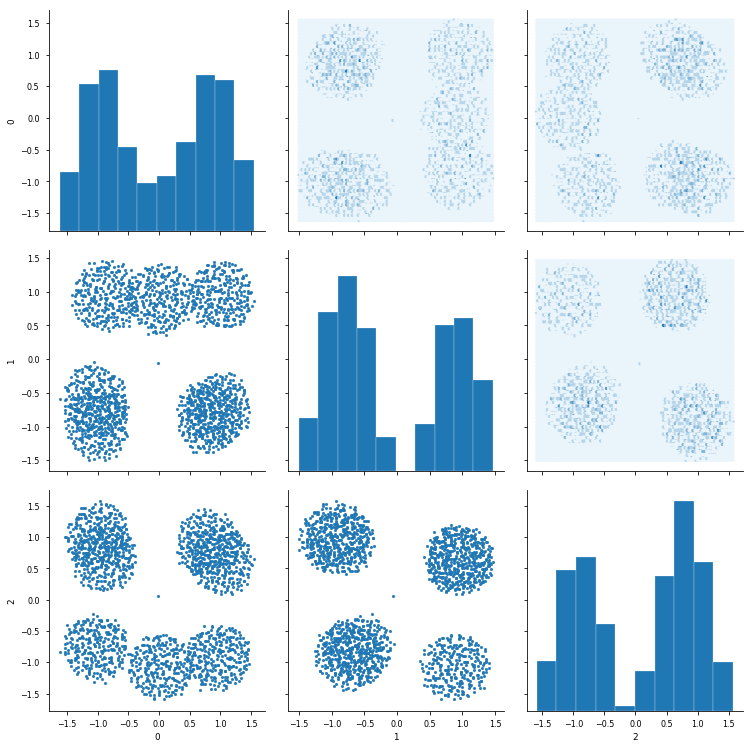

In [25]:
wgt_prod = wd2v.wgt_col
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

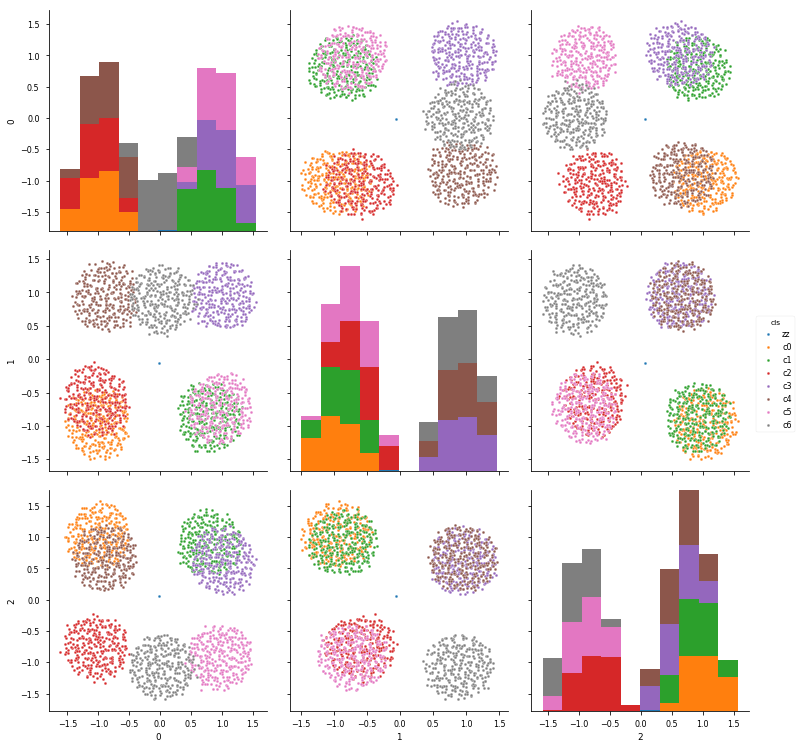

In [26]:
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['zz'] + ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


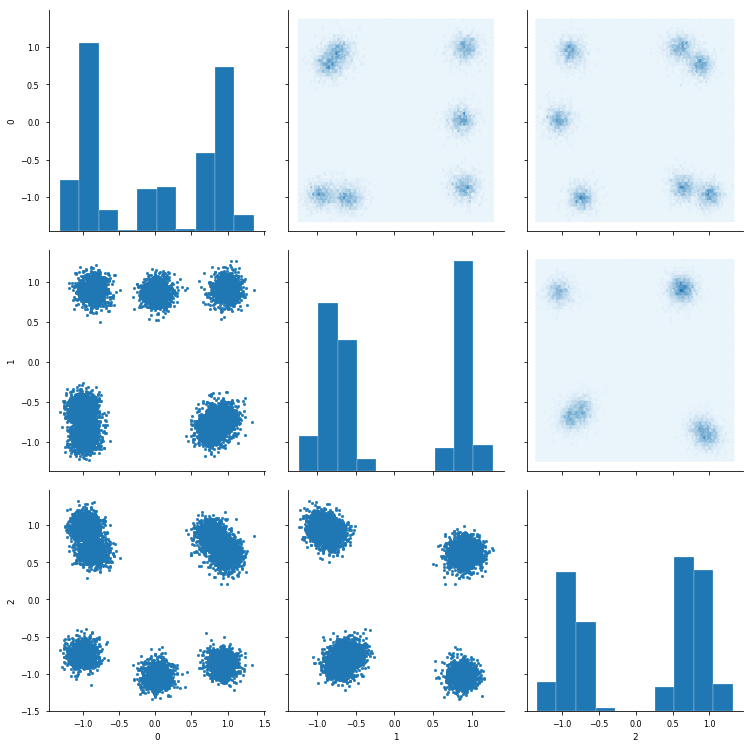

In [27]:
wgt_user = wd2v.wgt_row
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

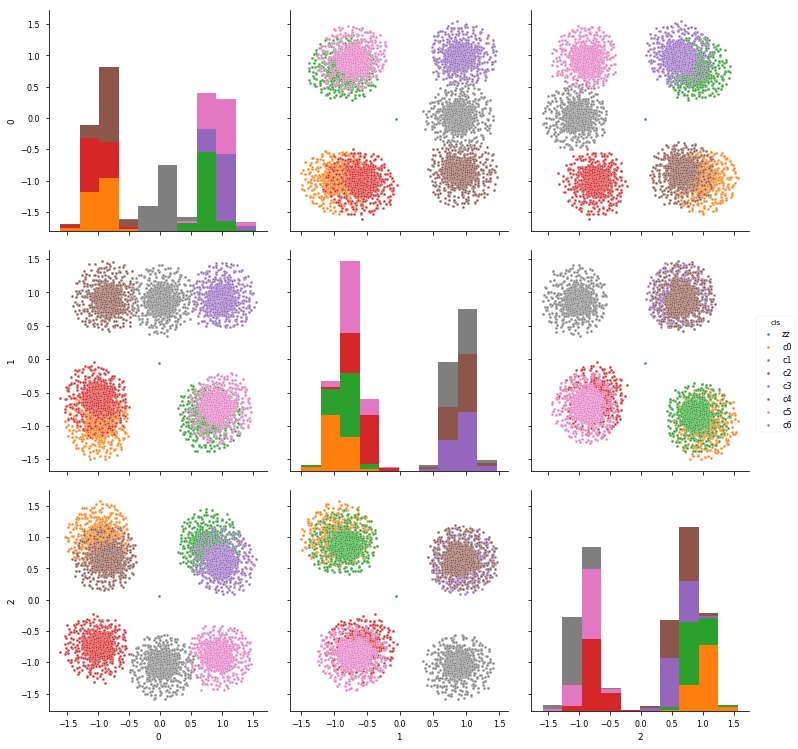

In [28]:
df = pd.DataFrame(np.vstack([wgt_prod, wgt_user])[:,:5])
df['cls'] = ['zz']+['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()
sns.pairplot(df, markers='.', hue='cls', size=3.5)

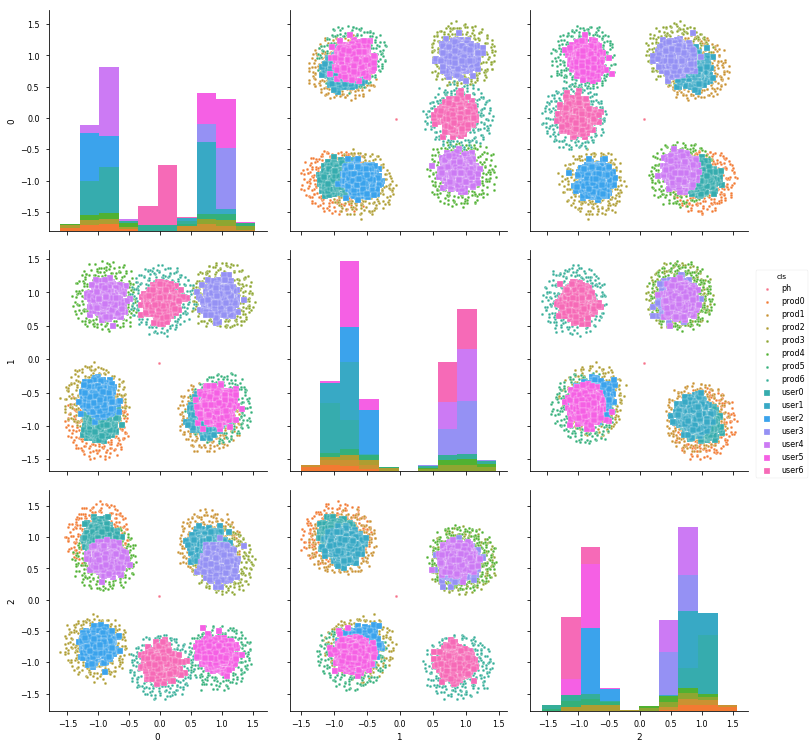

In [29]:
df1 = pd.DataFrame(wgt_prod)
df1['cls'] = ['ph'] + ['prod'+str(ii) for ii in cls_prod]
df2 = pd.DataFrame(wgt_user)
df2['cls'] = ['user'+str(ii) for ii in cls_user]
df = pd.concat([df1, df2], axis=0)
df.head()

sns.pairplot(df, markers=['.']*8+['s']*7, hue='cls', size=3.5)

In [30]:
sim = wd2v.sim
print(sim.num_features)
print(sim.sim_row)

3
MatrixSimilarity<10000 docs, 3 features>


In [31]:
query = sim.sim_row.index[sim.row_dic.token2id['r1']]
query

array([-0.5173851 , -0.5293421 ,  0.67239094], dtype=float32)

In [32]:
sim.get_sim_byrow(query, num_best=20)

[('r1', 1.0),
 ('r1415', 0.9999924898147583),
 ('r607', 0.9999780654907227),
 ('r225', 0.9999721646308899),
 ('r664', 0.9999476671218872),
 ('r1380', 0.9999459981918335),
 ('r260', 0.9999315738677979),
 ('r29', 0.9999307990074158),
 ('r92', 0.9999258518218994),
 ('r677', 0.9999161958694458),
 ('r994', 0.9999086856842041),
 ('r246', 0.9998948574066162),
 ('r1411', 0.9998902082443237),
 ('r452', 0.9998785257339478),
 ('r1077', 0.9998751878738403),
 ('r15', 0.9998675584793091),
 ('r1262', 0.9998642802238464),
 ('r1137', 0.9998518228530884),
 ('r946', 0.9998291730880737),
 ('r839', 0.9998033046722412)]